In [1]:
# make the necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
idx = pd.IndexSlice
import statsmodels.api as sm

from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Identification of Cointegrated Pairs of Stocks

In [2]:
# read back the pricing data
prices = pd.read_csv('metal.csv', index_col=['date'])
prices.head(10)

TATASTEEL.NS  HINDALCO.NS  JSWSTEEL.NS  ADANIENT.NS     VEDL.NS  \
date                                                                          
01-01-2018    688.066406   271.149994   265.799988    90.480850  325.450012   
02-01-2018    694.830810   271.899994   264.549988    89.309311  327.750000   
03-01-2018    700.213806   276.500000   268.700012    96.011597  332.500000   
04-01-2018    724.318054   279.799988   277.149994    99.880394  339.100006   
05-01-2018    734.274109   276.399994   285.100006   105.247673  339.549988   
08-01-2018    732.416321   276.149994   286.000000   107.045845  340.250000   
09-01-2018    735.798523   271.500000   284.000000   106.746147  337.700012   
10-01-2018    736.322510   268.799988   282.799988   108.326363  334.799988   
11-01-2018    734.512329   267.750000   282.549988   109.906578  333.899994   
12-01-2018    733.845398   268.850006   286.799988   108.953003  339.549988   

            COALINDIA.NS    SAIL.NS  JINDALSTEL.NS     NMDC.NS  APLAPOLLO.NS  
date                                                                          
01-01-2018    266.649994  92.699997     206.199997  141.050003    198.059998  
02-01-2018    270.049988  91.849998     203.399994  148.600006    198.014999  
03-01-2018    271.850006  93.800003     219.550003  149.250000    211.110001  
04-01-2018    277.799988  97.900002     244.550003  154.750000    229.990005  
05-01-2018    278.750000  97.400002     239.050003  158.550003    228.979996  
08-01-2018    287.450012  98.800003     256.450012  161.850006    228.110001  
09-01-2018    304.049988  97.949997     248.750000  154.699997    224.845001  
10-01-2018    308.299988  98.449997     262.399994  155.300003    221.845001  
11-01-2018    308.100006  98.500000     267.350006  155.350006    218.059998  
12-01-2018    309.000000  98.650002     264.850006  154.949997    222.729996

In [3]:
# train test split 
train_close, test_close = train_test_split(prices, test_size=0.251012, shuffle=False)

In [4]:
# quick view of head and tail of train set
train_close.head(2).append(train_close.tail(2))

TATASTEEL.NS  HINDALCO.NS  JSWSTEEL.NS  ADANIENT.NS     VEDL.NS  \
date                                                                          
01-01-2018    688.066406   271.149994   265.799988    90.480850  325.450012   
02-01-2018    694.830810   271.899994   264.549988    89.309311  327.750000   
30-12-2020    640.450012   237.399994   386.100006   484.149994  162.050003   
31-12-2020    643.650024   240.550003   387.200012   479.549988  161.399994   

            COALINDIA.NS    SAIL.NS  JINDALSTEL.NS     NMDC.NS  APLAPOLLO.NS  
date                                                                          
01-01-2018    266.649994  92.699997     206.199997  141.050003    198.059998  
02-01-2018    270.049988  91.849998     203.399994  148.600006    198.014999  
30-12-2020    135.600006  69.750000     265.950012  115.900002    417.674988  
31-12-2020    135.449997  74.099998     266.450012  114.449997    441.500000

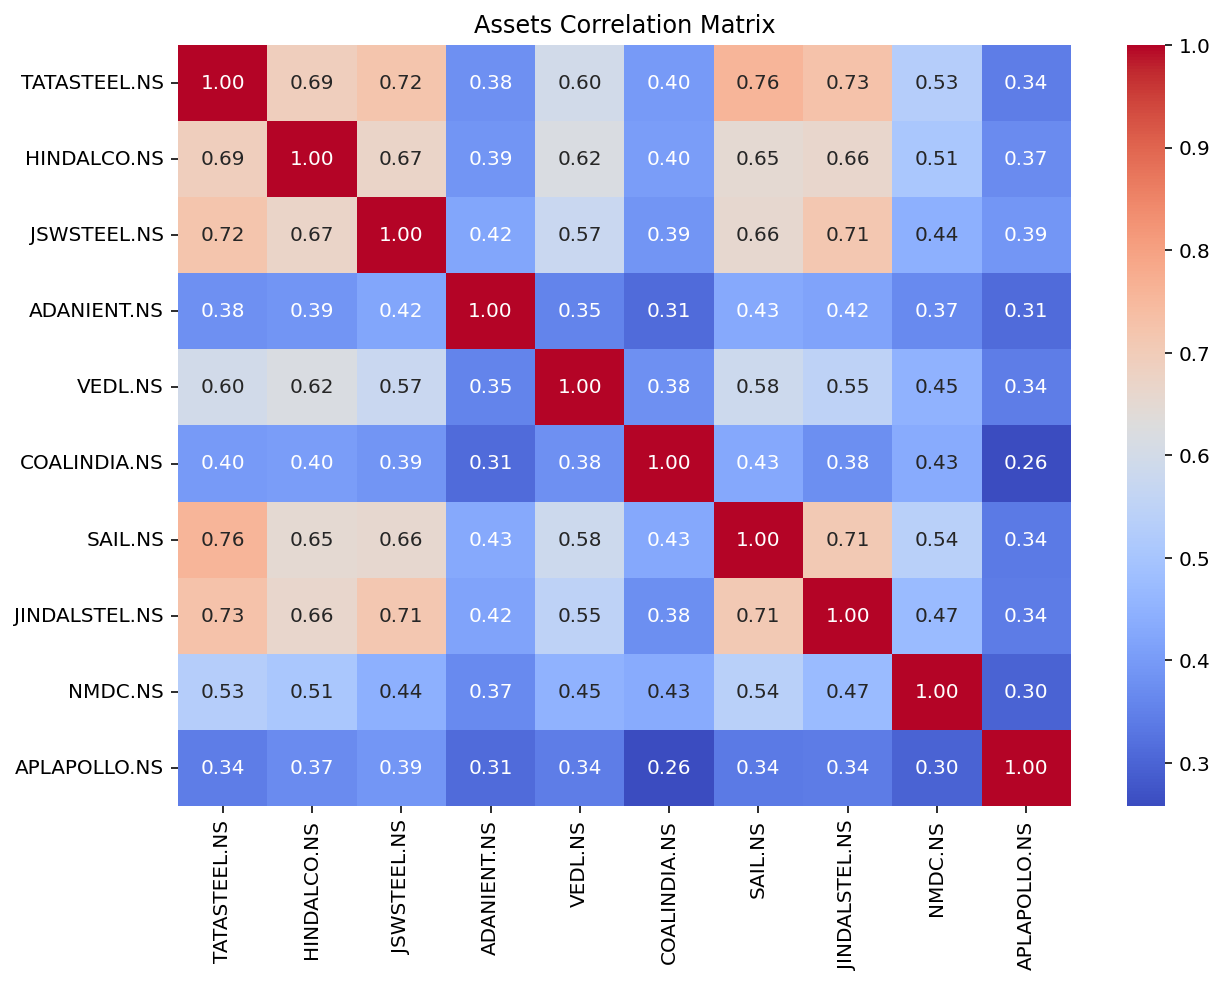

In [5]:
# Pearson correlation to get the basic idea about the relationship
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(train_close.pct_change().corr(method ='pearson'), ax=ax, cmap='coolwarm', annot=True, fmt=".2f") #spearman
ax.set_title('Assets Correlation Matrix')
plt.savefig('chart1', dpi=400)

In [6]:
# function to find cointegrated pairs
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] < 0.05:
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs

[('TATASTEEL.NS', 'JSWSTEEL.NS'), ('HINDALCO.NS', 'JSWSTEEL.NS')]


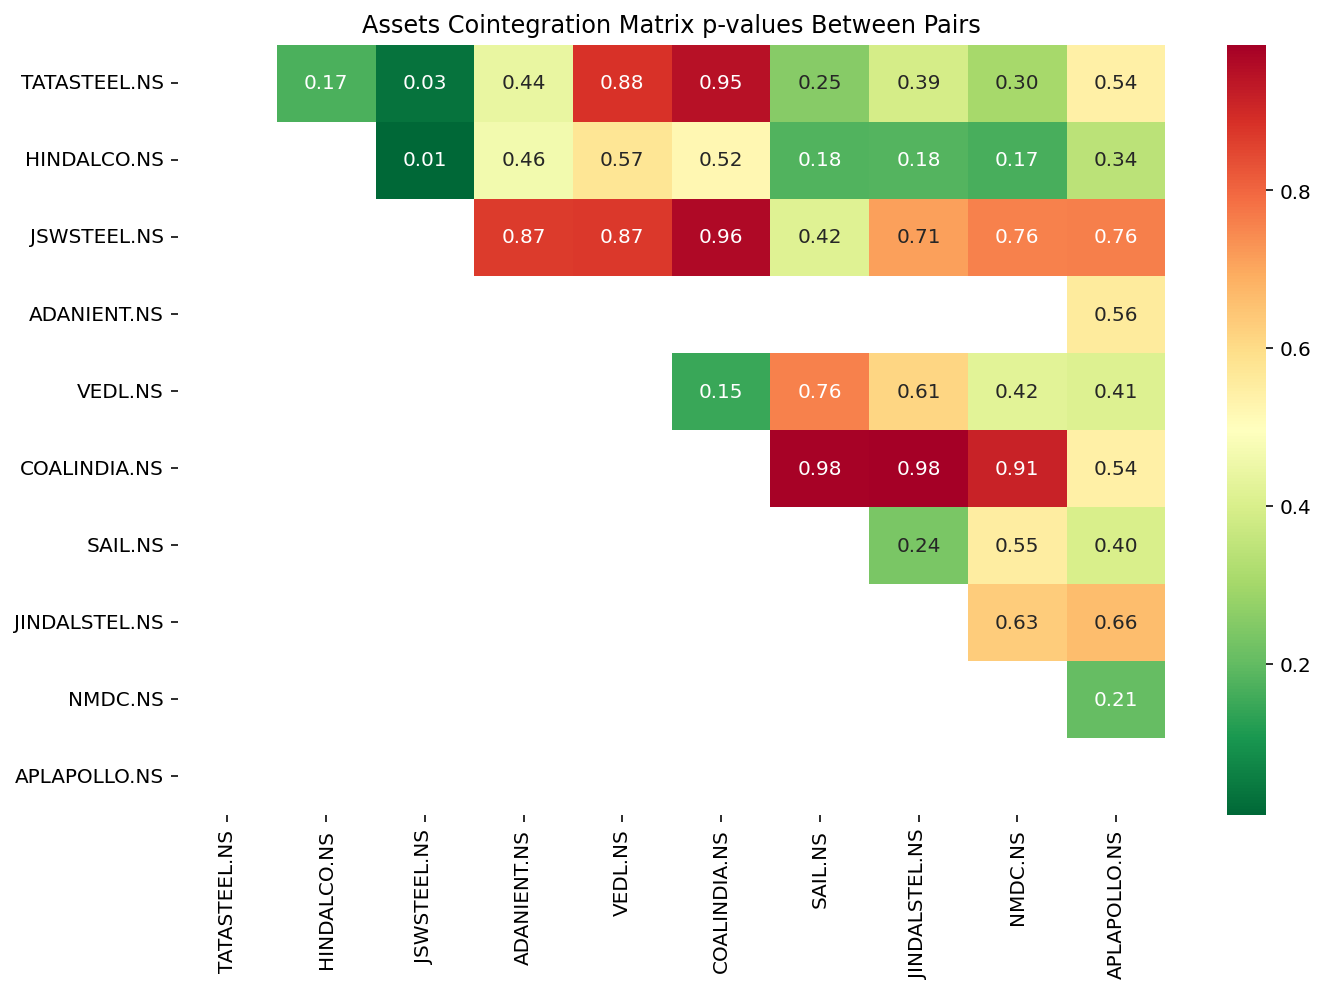

In [7]:
# calculate p-values and plot as a heatmap
pvalues, pairs = find_cointegrated_pairs(train_close)
print(pairs)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(pvalues, xticklabels = train_close.columns,
                yticklabels = train_close.columns, cmap = 'RdYlGn_r', annot = True, fmt=".2f",
                mask = (pvalues >= 0.99))
ax.set_title('Assets Cointegration Matrix p-values Between Pairs')
plt.tight_layout()
plt.savefig('chart2', dpi=400) 

### Perform a Cointegration test for the Selected Pair

In [8]:
# final pair to test strategy
asset1 = 'TATASTEEL.NS'
asset2 = 'HINDALCO.NS'

In [9]:
# create a train dataframe of 2 assets
train = pd.DataFrame()
train['asset1'] = train_close[asset1]
train['asset2'] = train_close[asset2]

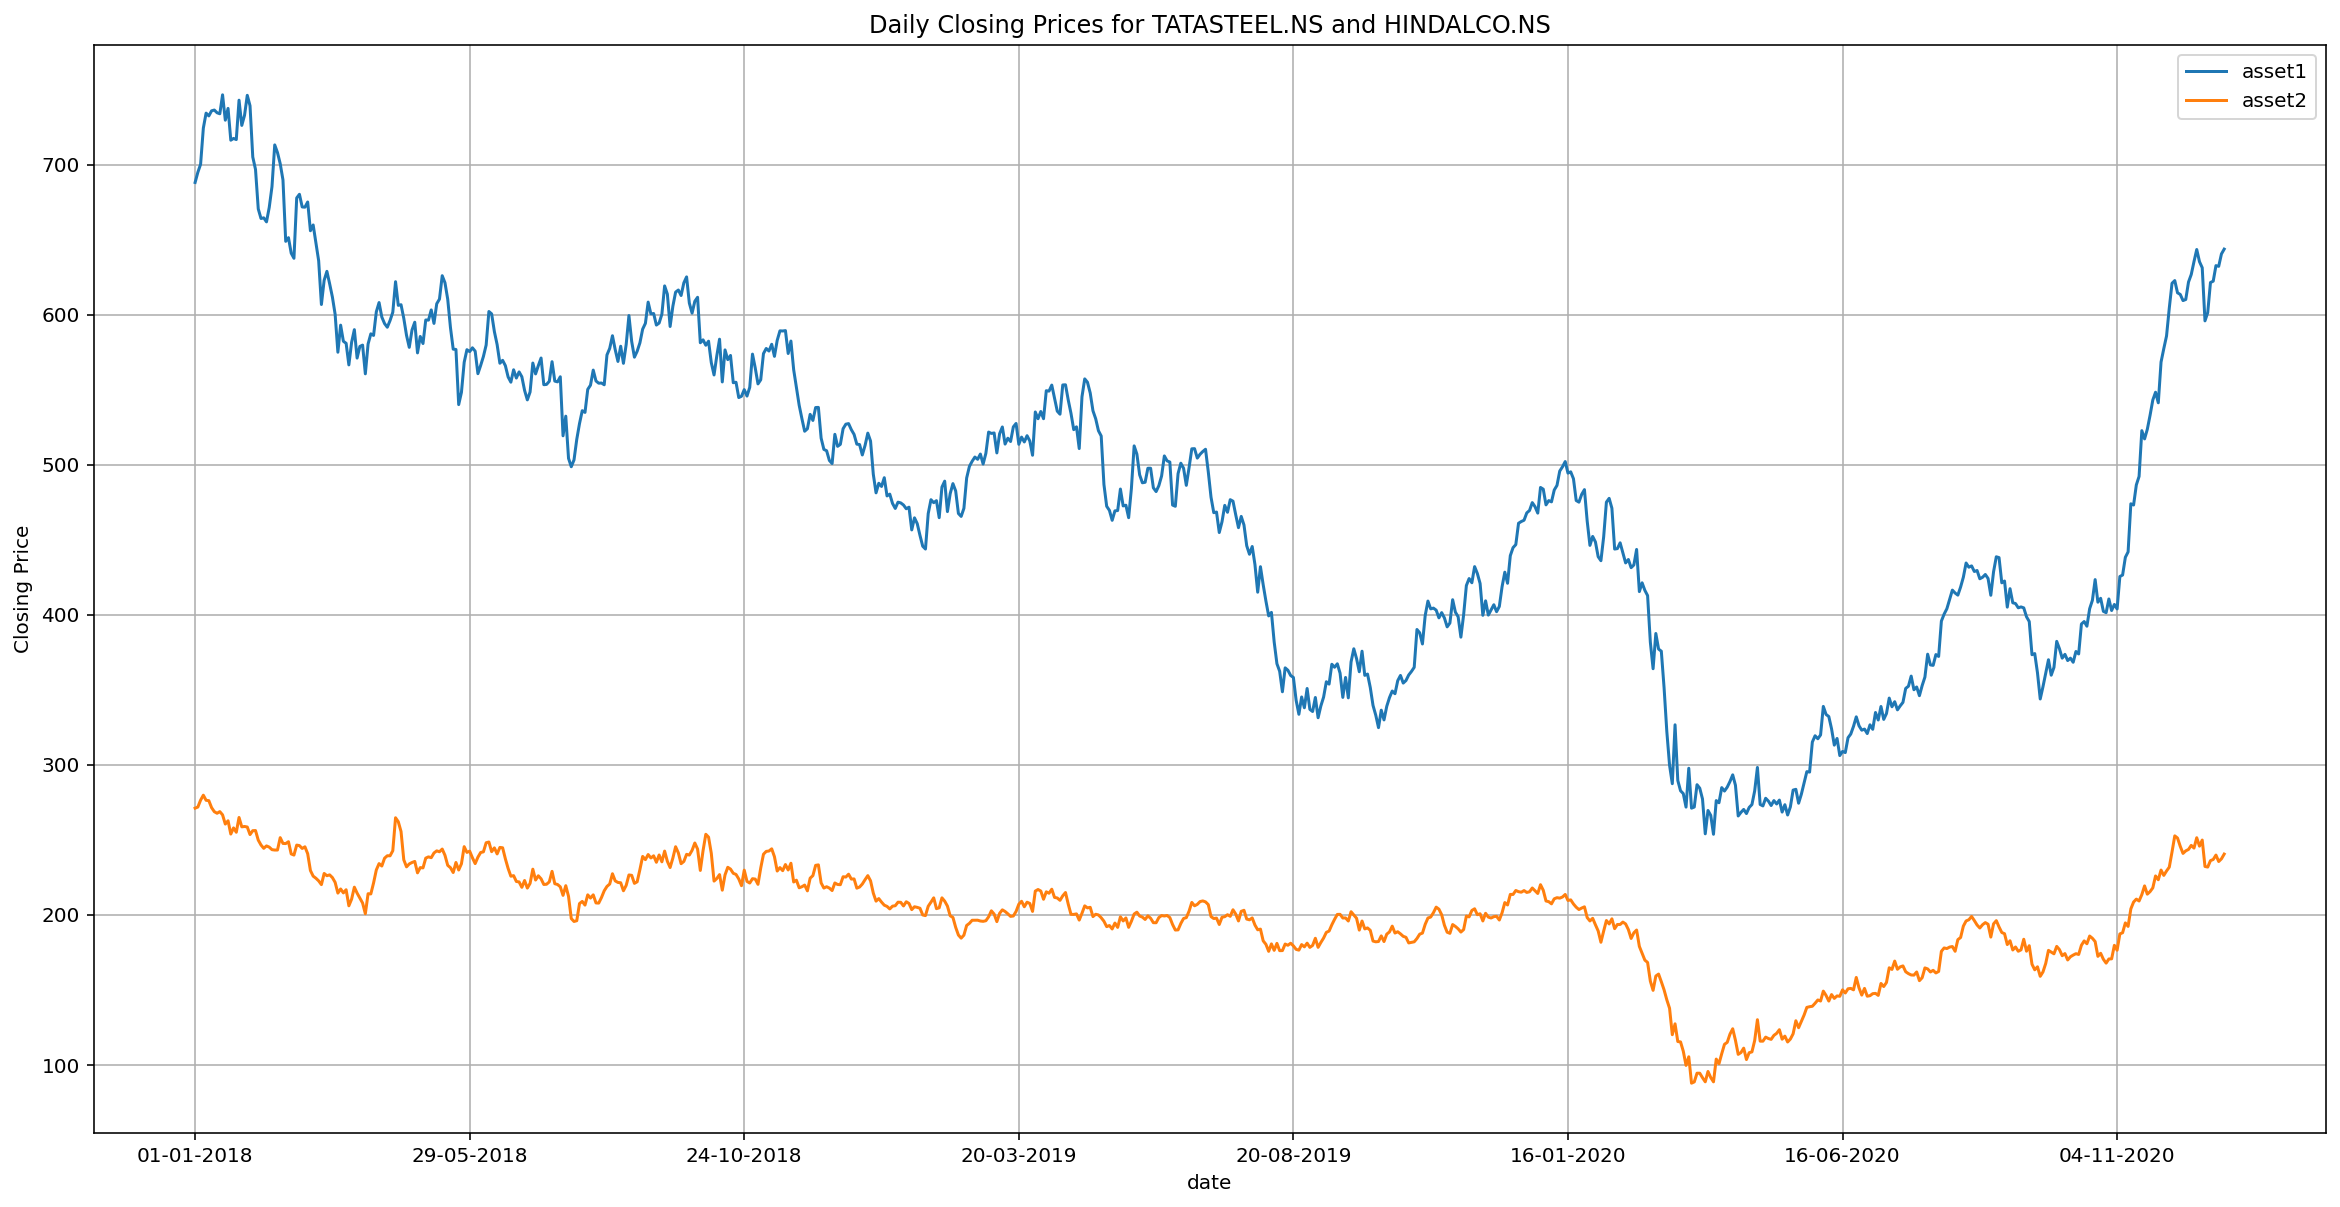

In [10]:
from matplotlib.dates import DateFormatter
# visualize closing prices
ax = train[['asset1','asset2']].plot(figsize=(20, 10), title = 'Daily Closing Prices for {} and {}'.format(asset1,asset2))
ax.set_ylabel("Closing Price")
#date_form = DateFormatter("%Y")
# ax.xaxis.set_major_formatter(date_form)
ax.grid(True);
plt.savefig('chart3', dpi=400) 

In [11]:
# run OLS regression
model=sm.OLS(train.asset2, train.asset1).fit()

In [12]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 asset2   R-squared (uncentered):                   0.991
Model:                            OLS   Adj. R-squared (uncentered):              0.991
Method:                 Least Squares   F-statistic:                          7.996e+04
Date:                Mon, 21 Mar 2022   Prob (F-statistic):                        0.00
Time:                        00:43:58   Log-Likelihood:                         -3247.5
No. Observations:                 740   AIC:                                      6497.
Df Residuals:                     739   BIC:                                      6502.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
asset1         0.4111      0.001    282.770      0.000       0.408       0.414
==============================================================================
Omnibus:                        1.073   Durbin-Watson:                   0.041
Prob(Omnibus):                  0.585   Jarque-Bera (JB):                0.969
Skew:                           0.085   Prob(JB):                        0.616
Kurtosis:                       3.051   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

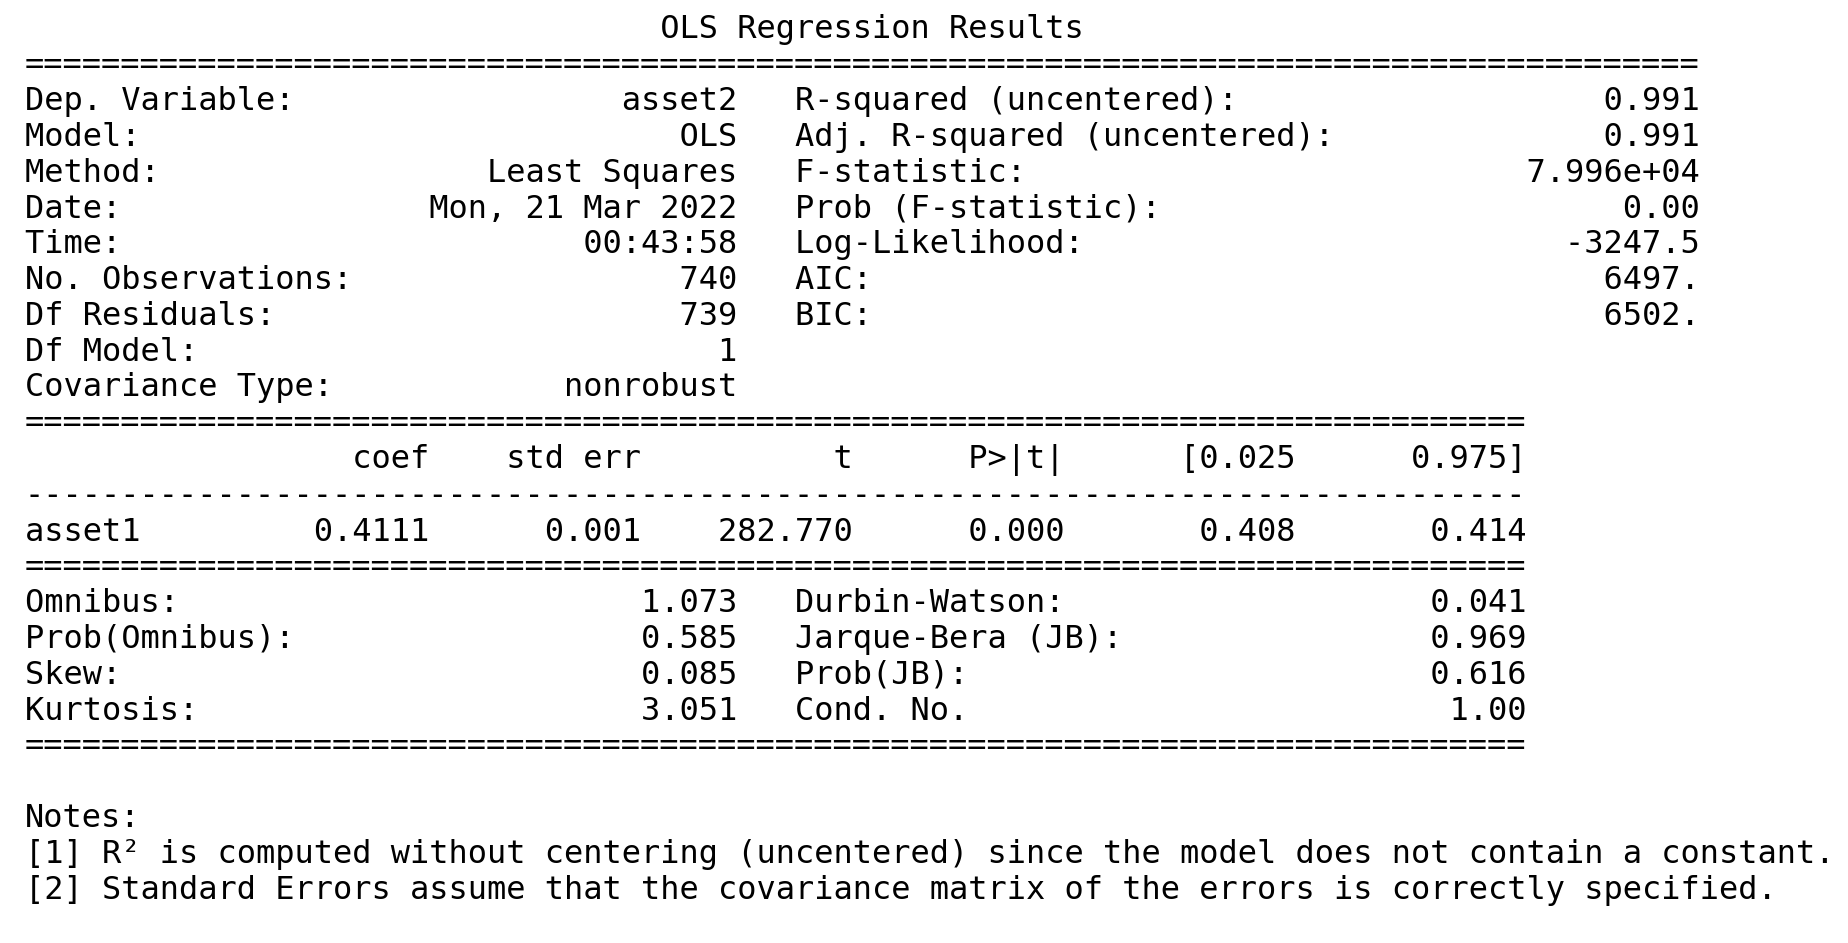

In [13]:
# print regression summary results
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 16}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.7, bottom=0.1)
plt.savefig('chart4', dpi=400);

In [14]:
print('Hedge Ratio = ', model.params[0])

Hedge Ratio =  0.4110760703129451


In [15]:
# calculate spread
spread = train.asset2 - model.params[0] * train.asset1

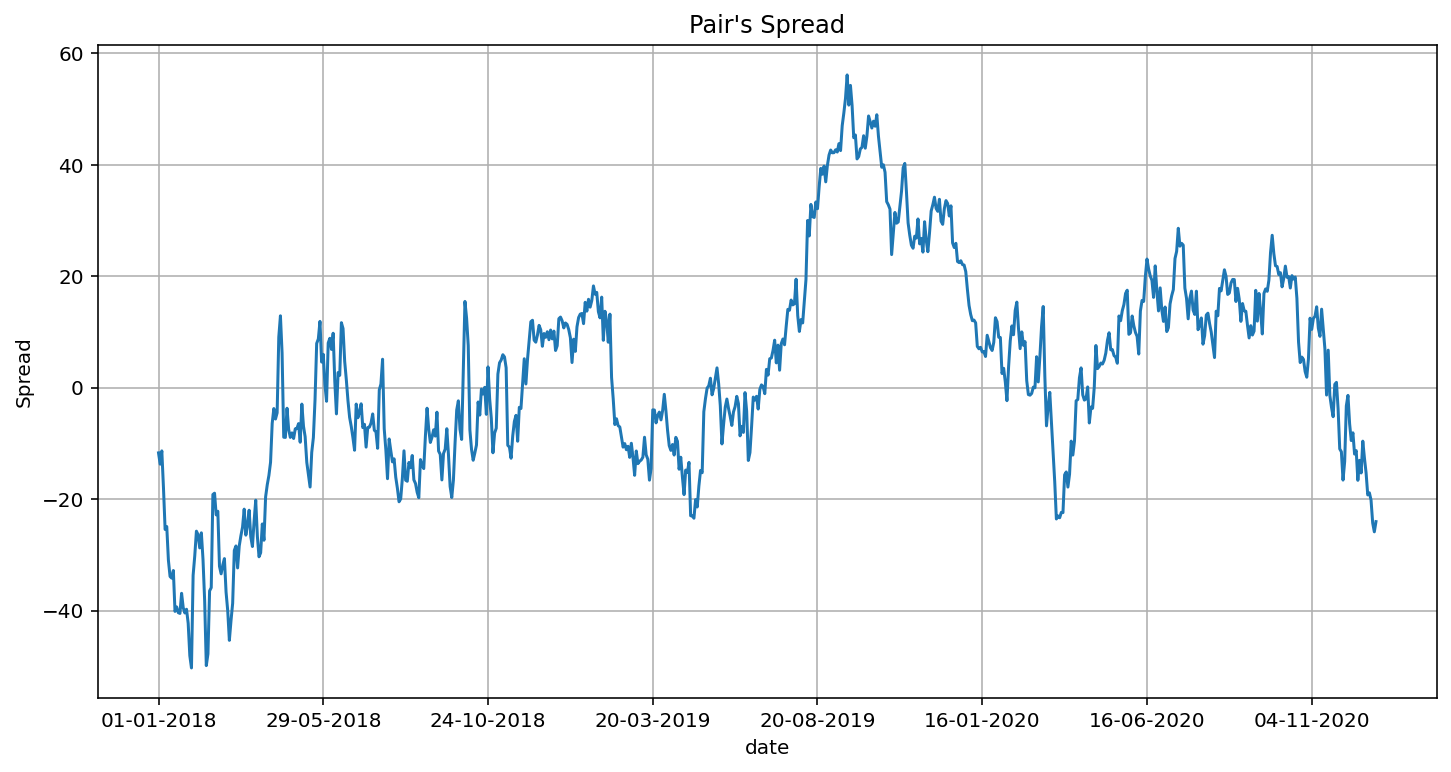

In [16]:
# Plot the spread
ax = spread.plot(figsize=(12, 6), title = "Pair's Spread")
ax.set_ylabel("Spread")
ax.grid(True);
plt.savefig('chart5', dpi=400);

In [17]:
# conduct Augmented Dickey-Fuller test
adf = adfuller(spread, maxlag = 1)
adf

(-2.6924277234909457,
 0.07535779465425847,
 0,
 739,
 {'1%': -3.439229783394421,
  '5%': -2.86545894814762,
  '10%': -2.5688568756191392},
 4127.081108453668)

In [18]:
print('Critical Value = ', adf[0])

Critical Value =  -2.6924277234909457


In [19]:
# probablity critical values
print(adf[4])

{'1%': -3.439229783394421, '5%': -2.86545894814762, '10%': -2.5688568756191392}


### Generate Trading Signals using z-score

In [20]:
# calculate z-score
def zscore(series):
    return (series - series.mean()) / np.std(series)

In [21]:
# create a dataframe for trading signals
signals = pd.DataFrame()
signals['asset1'] = test_close[asset1] 
signals['asset2'] = test_close[asset2]
ratios = signals.asset1 / signals.asset2

In [22]:
signals.head()

asset1      asset2
date                              
01-01-2021  643.099976  238.350006
04-01-2021  693.000000  254.300003
05-01-2021  680.549988  250.300003
06-01-2021  683.799988  259.049988
07-01-2021  722.799988  272.899994

In [23]:
# calculate z-score and define upper and lower thresholds
signals['z'] = zscore(ratios)
signals['z upper limit'] = np.mean(signals['z']) + np.std(signals['z'])
signals['z lower limit'] = np.mean(signals['z']) - np.std(signals['z'])

In [24]:
signals.head()

asset1      asset2         z  z upper limit  z lower limit
date                                                                      
01-01-2021  643.099976  238.350006 -0.159807            1.0           -1.0
04-01-2021  693.000000  254.300003 -0.075102            1.0           -1.0
05-01-2021  680.549988  250.300003 -0.094527            1.0           -1.0
06-01-2021  683.799988  259.049988 -0.343330            1.0           -1.0
07-01-2021  722.799988  272.899994 -0.315265            1.0           -1.0

In [25]:
# create signal - short if z-score is greater than upper limit else long
signals['signals1'] = 0
signals['signals1'] = np.select([signals['z'] > \
                                 signals['z upper limit'], signals['z'] < signals['z lower limit']], [-1, 1], default=0)

In [26]:
# we take the first order difference to obtain portfolio position in that stock
signals['positions1'] = signals['signals1'].diff()
signals['signals2'] = -signals['signals1']
signals['positions2'] = signals['signals2'].diff()

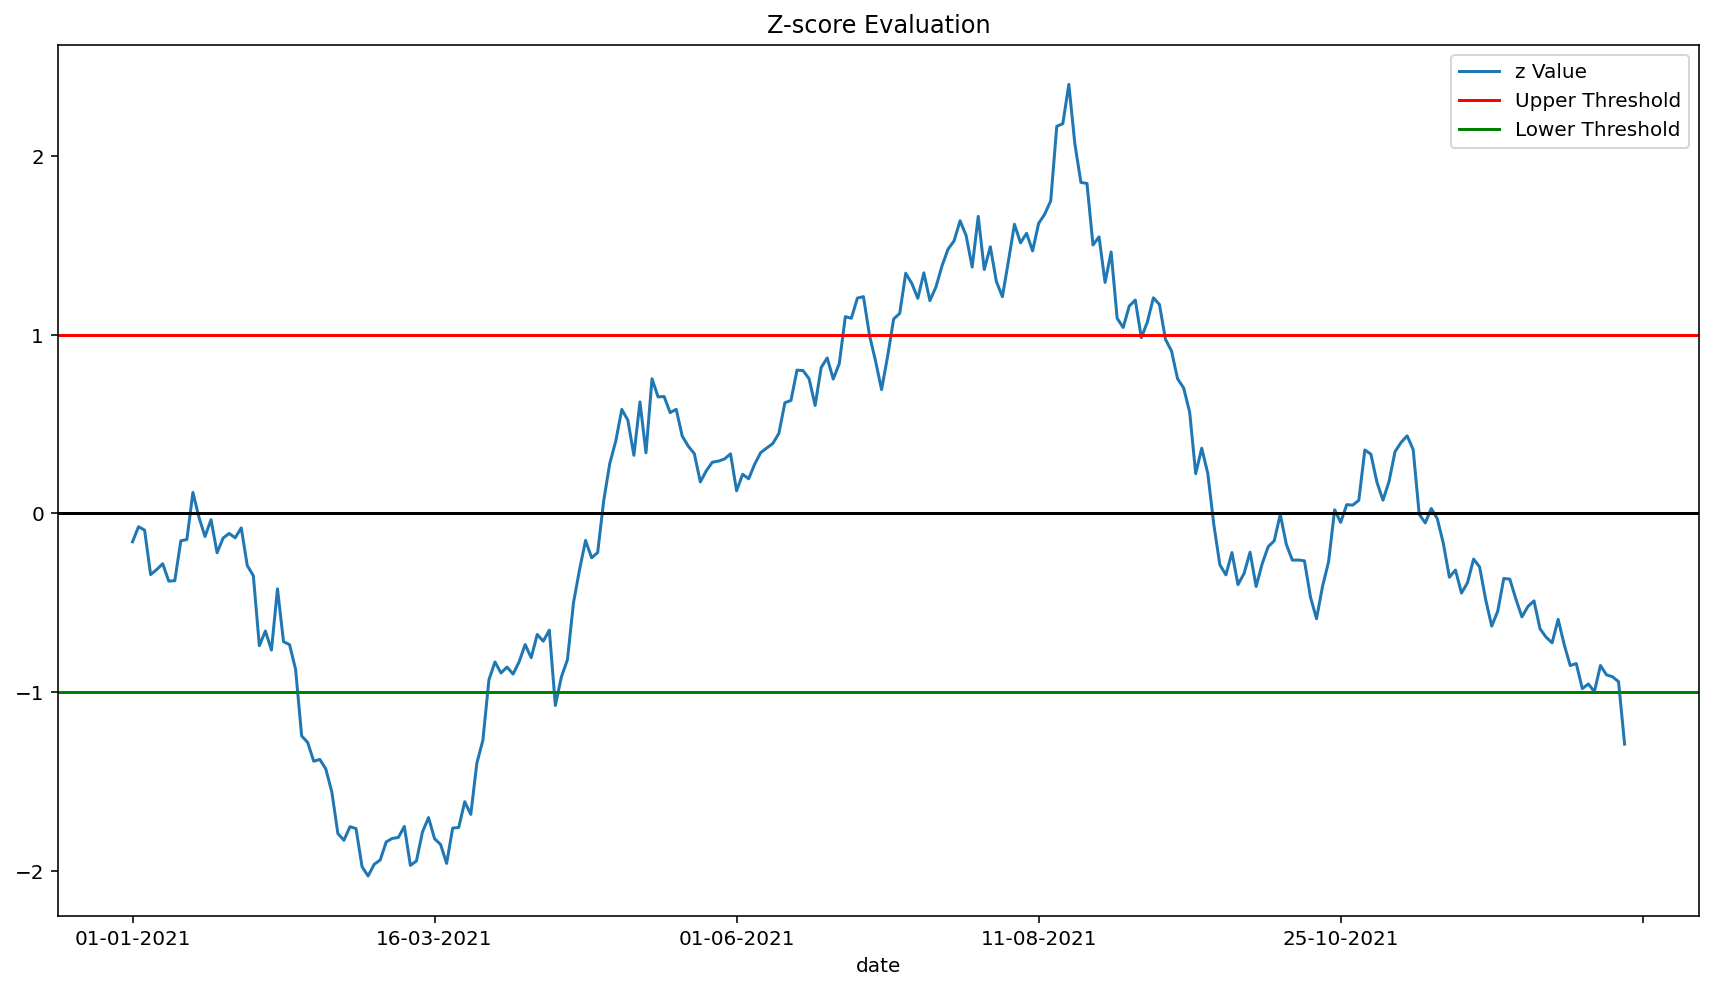

In [27]:
# # visualize z-score and upper and lower thresholds   
signals['z'].plot(label="z Value")
plt.title("Z-score Evaluation")
plt.axhline(signals['z'].mean(),color="black")
plt.axhline(signals['z upper limit'].mean(), color="red", label="Upper Threshold")
plt.axhline(signals['z lower limit'].mean(), color="green", label="Lower Threshold")
plt.legend()
plt.tight_layout()
plt.savefig('chart6', dpi=400);

In [28]:
# verify dataframe head and tail
signals.head(3).append(signals.tail(3))

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                          
01-01-2021   643.099976  238.350006 -0.159807            1.0           -1.0   
04-01-2021   693.000000  254.300003 -0.075102            1.0           -1.0   
05-01-2021   680.549988  250.300003 -0.094527            1.0           -1.0   
29-12-2021  1116.250000  454.250000 -0.915344            1.0           -1.0   
30-12-2021  1101.000000  449.649994 -0.942882            1.0           -1.0   
31-12-2021  1111.449951  475.549988 -1.292379            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         0         NaN         0         NaN  
04-01-2021         0         0.0         0         0.0  
05-01-2021         0         0.0         0         0.0  
29-12-2021         0         0.0         0         0.0  
30-12-2021         0         0.0         0         0.0  
31-12-2021         1         1.0        -1        -1.0

In [29]:
# # check portfolio position
signals[signals.signals1 != 0].head(10)

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                         
11-02-2021  694.700012  295.399994 -1.246761            1.0           -1.0   
12-02-2021  680.500000  290.799988 -1.283254            1.0           -1.0   
15-02-2021  672.150024  291.399994 -1.388286            1.0           -1.0   
16-02-2021  699.200012  302.700012 -1.378074            1.0           -1.0   
17-02-2021  696.799988  303.899994 -1.431474            1.0           -1.0   
18-02-2021  697.750000  309.899994 -1.561149            1.0           -1.0   
19-02-2021  670.700012  308.000000 -1.793144            1.0           -1.0   
22-02-2021  684.549988  316.100006 -1.830752            1.0           -1.0   
23-02-2021  729.299988  333.049988 -1.754976            1.0           -1.0   
24-02-2021  727.700012  332.799988 -1.764900            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
11-02-2021         1         1.0        -1        -1.0  
12-02-2021         1         0.0        -1         0.0  
15-02-2021         1         0.0        -1         0.0  
16-02-2021         1         0.0        -1         0.0  
17-02-2021         1         0.0        -1         0.0  
18-02-2021         1         0.0        -1         0.0  
19-02-2021         1         0.0        -1         0.0  
22-02-2021         1         0.0        -1         0.0  
23-02-2021         1         0.0        -1         0.0  
24-02-2021         1         0.0        -1         0.0

In [30]:
signals[signals.positions1 != 0].head().append(signals[signals.positions1 != 0].tail())

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                          
01-01-2021   643.099976  238.350006 -0.159807            1.0           -1.0   
11-02-2021   694.700012  295.399994 -1.246761            1.0           -1.0   
30-03-2021   800.000000  326.299988 -0.932965            1.0           -1.0   
16-04-2021   890.250000  370.000000 -1.076207            1.0           -1.0   
19-04-2021   888.049988  361.399994 -0.915651            1.0           -1.0   
07-07-2021  1218.650024  393.649994  1.087902            1.0           -1.0   
06-09-2021  1437.000000  469.250000  0.982983            1.0           -1.0   
07-09-2021  1428.699951  462.299988  1.071105            1.0           -1.0   
13-09-2021  1463.449951  478.350006  0.973686            1.0           -1.0   
31-12-2021  1111.449951  475.549988 -1.292379            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         0         NaN         0         NaN  
11-02-2021         1         1.0        -1        -1.0  
30-03-2021         0        -1.0         0         1.0  
16-04-2021         1         1.0        -1        -1.0  
19-04-2021         0        -1.0         0         1.0  
07-07-2021        -1        -1.0         1         1.0  
06-09-2021         0         1.0         0        -1.0  
07-09-2021        -1        -1.0         1         1.0  
13-09-2021         0         1.0         0        -1.0  
31-12-2021         1         1.0        -1        -1.0

In [31]:
signals.loc[signals['positions1'] == 1].index
signals['asset1'][signals['positions1'] == 1].value_counts()

694.700012     1
890.250000     1
1163.550049    1
1437.000000    1
1463.449951    1
1111.449951    1
Name: asset1, dtype: int64

In [32]:
signals

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                          
01-01-2021   643.099976  238.350006 -0.159807            1.0           -1.0   
04-01-2021   693.000000  254.300003 -0.075102            1.0           -1.0   
05-01-2021   680.549988  250.300003 -0.094527            1.0           -1.0   
06-01-2021   683.799988  259.049988 -0.343330            1.0           -1.0   
07-01-2021   722.799988  272.899994 -0.315265            1.0           -1.0   
...                 ...         ...       ...            ...            ...   
27-12-2021  1121.800049  452.799988 -0.852192            1.0           -1.0   
28-12-2021  1127.449951  458.149994 -0.904274            1.0           -1.0   
29-12-2021  1116.250000  454.250000 -0.915344            1.0           -1.0   
30-12-2021  1101.000000  449.649994 -0.942882            1.0           -1.0   
31-12-2021  1111.449951  475.549988 -1.292379            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         0         NaN         0         NaN  
04-01-2021         0         0.0         0         0.0  
05-01-2021         0         0.0         0         0.0  
06-01-2021         0         0.0         0         0.0  
07-01-2021         0         0.0         0         0.0  
...              ...         ...       ...         ...  
27-12-2021         0         0.0         0         0.0  
28-12-2021         0         0.0         0         0.0  
29-12-2021         0         0.0         0         0.0  
30-12-2021         0         0.0         0         0.0  
31-12-2021         1         1.0        -1        -1.0  

[248 rows x 9 columns]

In [33]:
signals = signals.reset_index()

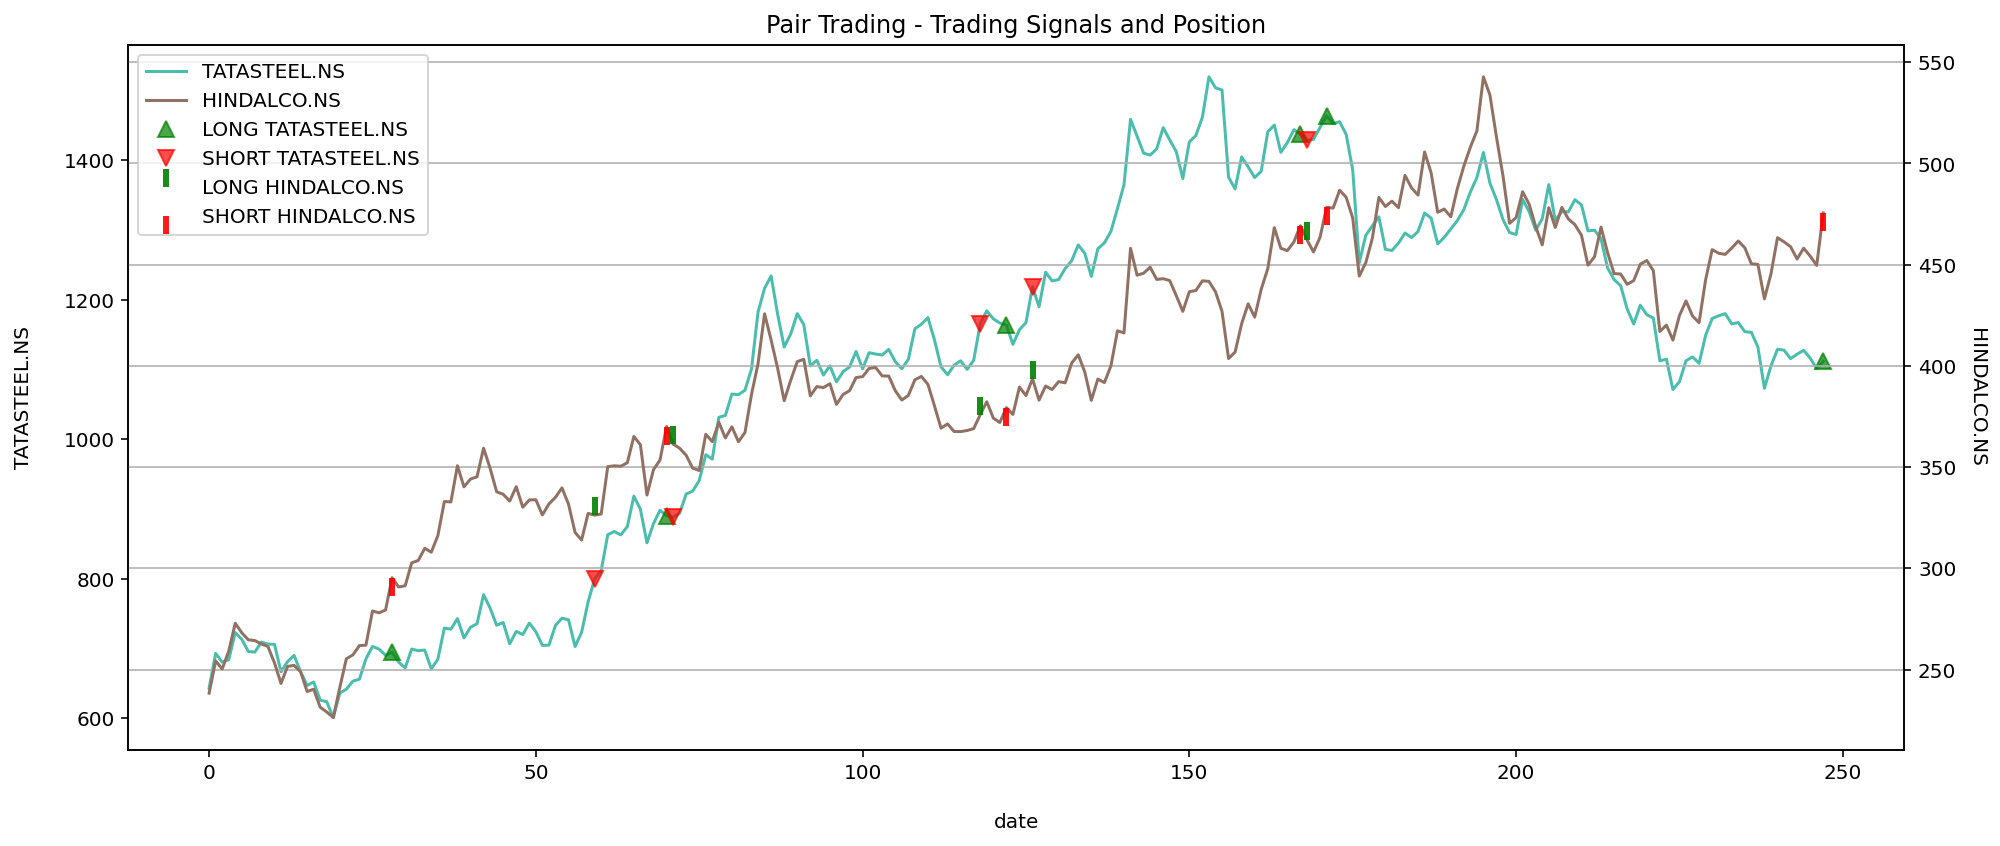

In [34]:
# visualize trading signals and position
fig=plt.figure(figsize=(14,6))
bx = fig.add_subplot(111)   
bx2 = bx.twinx()

#plot two different assets
l1, = bx.plot(signals['asset1'], c='#4abdac')
l2, = bx2.plot(signals['asset2'], c='#907163')

u1, = bx.plot(signals['asset1'][signals['positions1'] == 1], lw=0, marker='^', markersize=8, c='g',alpha=0.7)

d1, = bx.plot(signals['asset1'][signals['positions1'] == -1], lw=0,marker='v',markersize=8, c='r',alpha=0.7)

u2, = bx2.plot(signals['asset2'][signals['positions2'] == 1], lw=0,marker=2,markersize=9, c='g',alpha=0.9, markeredgewidth=3)

d2, = bx2.plot(signals['asset2'][signals['positions2'] == -1], lw=0,marker=3,markersize=9, c='r',alpha=0.9,markeredgewidth=3)

bx.set_ylabel(asset1,)
bx2.set_ylabel(asset2, rotation=270)
bx.yaxis.labelpad=15
bx2.yaxis.labelpad=15
bx.set_xlabel('date')
# bx.xaxis.set_major_formatter(DateFormatter("%Y"))
# bx2.xaxis.set_major_formatter(DateFormatter("%Y"))
bx.xaxis.labelpad=15

plt.legend([l1,l2,u1,d1,u2,d2], [asset1, asset2,'LONG {}'.format(asset1),
           'SHORT {}'.format(asset1),
           'LONG {}'.format(asset2),
           'SHORT {}'.format(asset2)], loc ='best')

plt.title('Pair Trading - Trading Signals and Position')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.savefig('chart7', dpi=400);

### Portfolio Profit and Loss Calculation

In [35]:
# initial capital to calculate the actual pnl
initial_capital = 100000

# shares to buy for each position
positions1 = initial_capital// max(signals['asset1'])
positions2 = initial_capital// max(signals['asset2'])

In [36]:
# since there are two assets, we calculate each asset Pnl separately 
# and in the end we aggregate them into one portfolio
portfolio = pd.DataFrame()
portfolio['asset1'] = signals['asset1']
portfolio['holdings1'] = signals['positions1'].cumsum() * signals['asset1'] * positions1
portfolio['cash1'] = initial_capital - (signals['positions1'] * signals['asset1'] * positions1).cumsum()
portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
portfolio['return1'] = portfolio['total asset1'].pct_change()
portfolio['positions1'] = signals['positions1']

In [37]:
portfolio.head().append(portfolio.tail())

asset1     holdings1          cash1   total asset1  return1  \
0     643.099976           NaN            NaN            NaN      NaN   
1     693.000000      0.000000  100000.000000  100000.000000      NaN   
2     680.549988      0.000000  100000.000000  100000.000000      0.0   
3     683.799988      0.000000  100000.000000  100000.000000      0.0   
4     722.799988      0.000000  100000.000000  100000.000000      0.0   
243  1121.800049      0.000000   90360.496789   90360.496789      0.0   
244  1127.449951      0.000000   90360.496789   90360.496789      0.0   
245  1116.250000      0.000000   90360.496789   90360.496789      0.0   
246  1101.000000      0.000000   90360.496789   90360.496789      0.0   
247  1111.449951  72244.246815   18116.249974   90360.496789      0.0   

     positions1  
0           NaN  
1           0.0  
2           0.0  
3           0.0  
4           0.0  
243         0.0  
244         0.0  
245         0.0  
246         0.0  
247         1.0

In [38]:
portfolio[portfolio.positions1 != 0].head()

asset1     holdings1          cash1   total asset1   return1  \
0   643.099976           NaN            NaN            NaN       NaN   
28  694.700012  45155.500793   54844.499207  100000.000000  0.000000   
59  800.000000      0.000000  106844.499207  106844.499207  0.020582   
70  890.250000  57866.250000   48978.249207  106844.499207  0.000000   
71  888.049988      0.000000  106701.498414  106701.498414 -0.001338   

    positions1  
0          NaN  
28         1.0  
59        -1.0  
70         1.0  
71        -1.0

In [39]:
# pnl for the 2nd asset
portfolio['asset2'] = signals['asset2']
portfolio['holdings2'] = signals['positions2'].cumsum() * signals['asset2'] * positions2
portfolio['cash2'] = initial_capital - (signals['positions2'] * signals['asset2'] * positions2).cumsum()
portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
portfolio['return2'] = portfolio['total asset2'].pct_change()
portfolio['positions2'] = signals['positions2']

In [40]:
portfolio.to_csv('portfolio.csv')
portfolio.head().append(portfolio.tail())

asset1     holdings1          cash1   total asset1  return1  \
0     643.099976           NaN            NaN            NaN      NaN   
1     693.000000      0.000000  100000.000000  100000.000000      NaN   
2     680.549988      0.000000  100000.000000  100000.000000      0.0   
3     683.799988      0.000000  100000.000000  100000.000000      0.0   
4     722.799988      0.000000  100000.000000  100000.000000      0.0   
243  1121.800049      0.000000   90360.496789   90360.496789      0.0   
244  1127.449951      0.000000   90360.496789   90360.496789      0.0   
245  1116.250000      0.000000   90360.496789   90360.496789      0.0   
246  1101.000000      0.000000   90360.496789   90360.496789      0.0   
247  1111.449951  72244.246815   18116.249974   90360.496789      0.0   

     positions1      asset2     holdings2          cash2   total asset2  \
0           NaN  238.350006           NaN            NaN            NaN   
1           0.0  254.300003      0.000000  100000.000000  100000.000000   
2           0.0  250.300003      0.000000  100000.000000  100000.000000   
3           0.0  259.049988      0.000000  100000.000000  100000.000000   
4           0.0  272.899994      0.000000  100000.000000  100000.000000   
243         0.0  452.799988      0.000000  113404.406734  113404.406734   
244         0.0  458.149994      0.000000  113404.406734  113404.406734   
245         0.0  454.250000      0.000000  113404.406734  113404.406734   
246         0.0  449.649994      0.000000  113404.406734  113404.406734   
247         1.0  475.549988 -87501.197755  200905.604490  113404.406734   

     return2  positions2  
0        NaN         NaN  
1        NaN         0.0  
2        0.0         0.0  
3        0.0         0.0  
4        0.0         0.0  
243      0.0         0.0  
244      0.0         0.0  
245      0.0         0.0  
246      0.0         0.0  
247      0.0        -1.0

In [41]:
portfolio[portfolio.positions2 != 0].head()

asset1     holdings1          cash1   total asset1   return1  \
0   643.099976           NaN            NaN            NaN       NaN   
28  694.700012  45155.500793   54844.499207  100000.000000  0.000000   
59  800.000000      0.000000  106844.499207  106844.499207  0.020582   
70  890.250000  57866.250000   48978.249207  106844.499207  0.000000   
71  888.049988      0.000000  106701.498414  106701.498414 -0.001338   

    positions1      asset2     holdings2          cash2   total asset2  \
0          NaN  238.350006           NaN            NaN            NaN   
28         1.0  295.399994 -54353.598878  154353.598878  100000.000000   
59        -1.0  326.299988      0.000000   94314.401122   94314.401122   
70         1.0  370.000000 -68080.000000  162394.401122   94314.401122   
71        -1.0  361.399994      0.000000   95896.802245   95896.802245   

         return2  positions2  
0            NaN         NaN  
28 -1.110223e-16        -1.0  
59  1.661050e-03         1.0  
70  2.220446e-16        -1.0  
71  1.677794e-02         1.0

In [42]:
# total pnl and z-score
portfolio['z'] = signals['z']
portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
portfolio['z upper limit'] = signals['z upper limit']
portfolio['z lower limit'] = signals['z lower limit']
portfolio = portfolio.dropna()

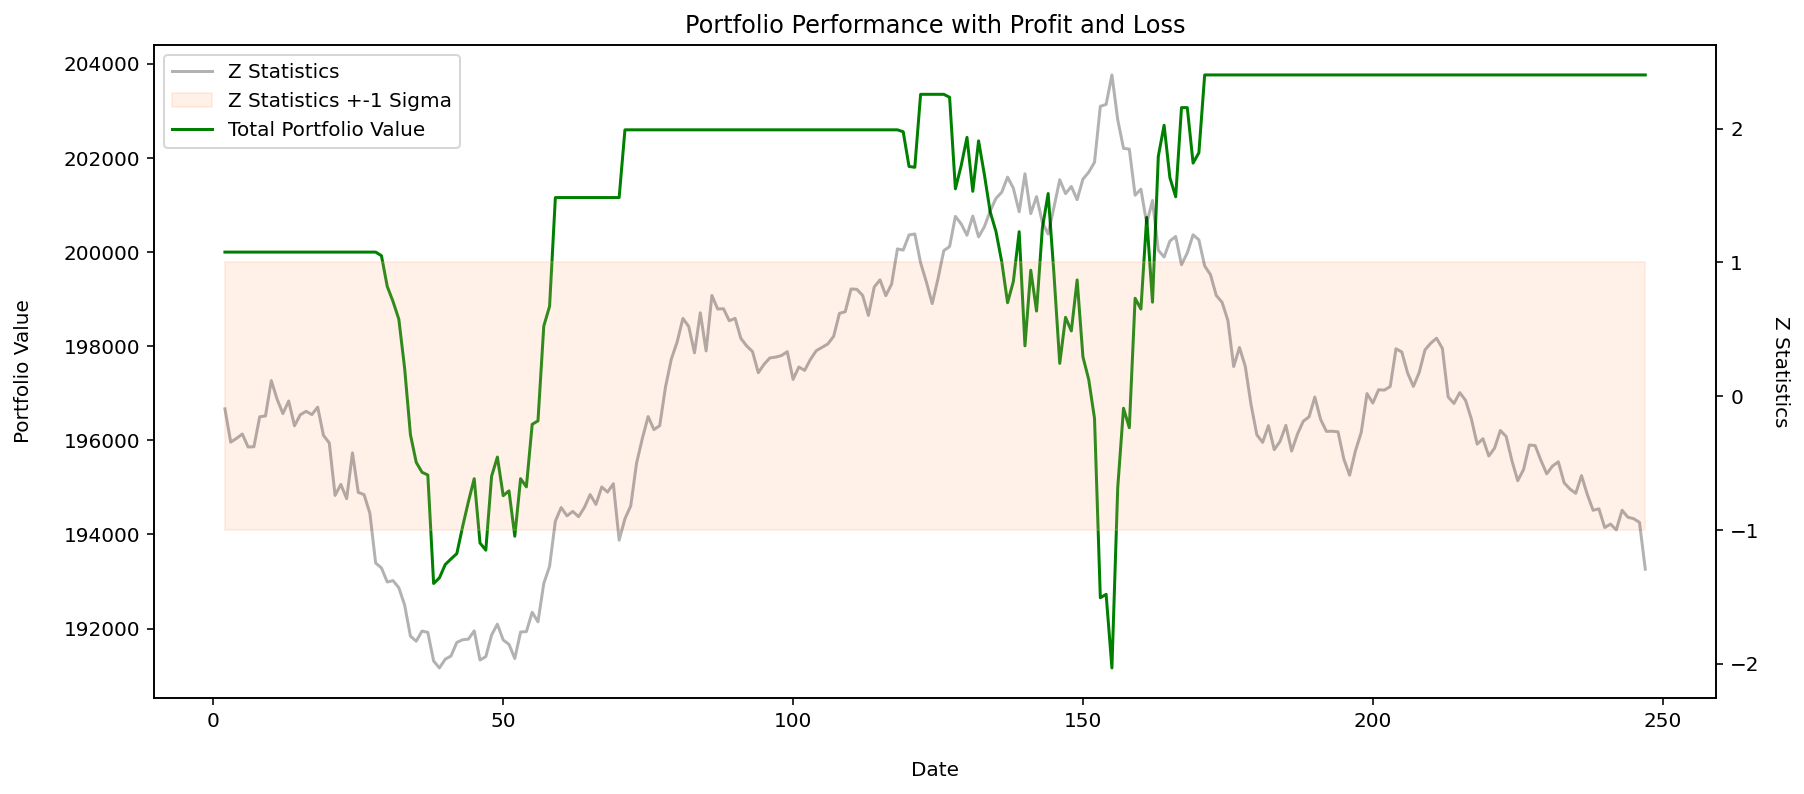

In [43]:
# plot the asset value change of the portfolio and pnl along with z-score
fig = plt.figure(figsize=(14,6),)
ax = fig.add_subplot(111)
ax2 = ax.twinx()

l1, = ax.plot(portfolio['total asset'], c='g')
l2, = ax2.plot(portfolio['z'], c='black', alpha=0.3)

b = ax2.fill_between(portfolio.index,portfolio['z upper limit'],\
                portfolio['z lower limit'], \
                alpha=0.2,color='#ffb48f')

ax.set_ylabel('Portfolio Value')
ax2.set_ylabel('Z Statistics',rotation=270)
ax.yaxis.labelpad=15
ax2.yaxis.labelpad=15
ax.set_xlabel('Date')
ax.xaxis.labelpad=15
plt.title('Portfolio Performance with Profit and Loss')
plt.legend([l2,b,l1],['Z Statistics',
                      'Z Statistics +-1 Sigma',
                      'Total Portfolio Value'],loc='upper left');
plt.savefig('chart8', dpi=400);

In [44]:
#portfolio = pd.read_csv('portfolio.csv')

In [47]:
# calculate CAGR
final_portfolio = portfolio['total asset'].iloc[-1]
final_portfolio

203764.90352340002

In [48]:
profit = final_portfolio - 2*initial_capital
profit

3764.9035234000185

In [49]:
roi = (profit/(2*initial_capital))*100
roi

1.8824517617000092

In [ ]:
# delta = (portfolio.index[-1] - portfolio.index[0]).days
delta = (portfolio.index[-1] - portfolio.index[0])
print('Number of days = ', delta)

In [46]:
YEAR_DAYS = 365
returns = (final_portfolio/initial_capital) ** (YEAR_DAYS/delta) - 1
print('CAGR = {:.3f}%' .format(returns * 100))

CAGR = 188.762%
